### Lesion Segmentation

This is the notebook to run both binary and multiclass lesion segmentation with UNET.

The first part contains common imports:
1. uNet model architecture
2. Loss functions
3. Train, Eval, Inference functions
4. Common Dataset Imports (custom transforms, unnormalise, visualise dataset)

The second part involves training binary and multiclass lesion segmentations seperately

This notebook assumes the following project structure:
```bash
Root
├── notebooks
│   └── notebook1.ipynb
└── input
    └── IDRID
        ├── 1. Original Images
        │   ├── a. Training Set
        │   └── b. Testing Set
        └── 2. All Segmentation Groundtruths
            ├── a. Training Set
            └── b. Testing Set
                ├── 1. Microaneurysms
                ├── 2. Haemorrhages
                ├── 3. Hard Exudates
                ├── 4. Soft Exudates
                └── 5. Optic Disc
```

If you do not have the dataset, you may download it from our Google Drive or from here:<br>
https://ieee-dataport.org/open-access/indian-diabetic-retinopathy-image-dataset-idrid 

Please install the A. Segmentation.zip and move the dataset into this folder structure

In [2]:
# Imports
import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image, ImageOps
import numpy as np
import random
from tqdm import tqdm
import math
import pandas as pd
import gc

### UNET model Architecture

UNET is made out of 3 main architectures
1. Encoder block made out of convolutional blocks
2. BottleNeck layer made out of 2 conv2d
3. Decoder block made out of transpose convolutional blocks


In [3]:
class conv_block(torch.nn.Module):
  """convolutional block for that UNET"""
  def __init__(self, in_channels:int, out_channels:int):
    super(conv_block, self).__init__()
    self.conv1 = torch.nn.Conv2d(in_channels, out_channels, 3, padding=1)
    self.bn1 = torch.nn.BatchNorm2d(out_channels)
    self.conv2 = torch.nn.Conv2d(out_channels, out_channels, 3, padding=1)
    self.bn2 = torch.nn.BatchNorm2d(out_channels)
    self.relu = torch.nn.ReLU()

  def forward(self, inputs):
    x = self.relu(self.bn1(self.conv1(inputs)))
    x = self.relu(self.bn2(self.conv2(x)))
    return x

In [4]:
class encoder_block(torch.nn.Module):
  """ 
  encoder block that includes convolutional block and maxpooling
  returns both values before maxpool and after maxpool (for skip connections)
  """ 
  def __init__(self, in_channels:int, out_channels:int):
    super(encoder_block, self).__init__()
    self.conv = conv_block(in_channels, out_channels)
    self.maxpool = torch.nn.MaxPool2d((2,2))

  def forward(self, inputs):
    x = self.conv(inputs)
    p = self.maxpool(x)
    return x, p

In [5]:
class decoder_block(torch.nn.Module):
  """
  decoder block that upsamples images and takes in skip connections
  """
  def __init__(self, in_channels:int, out_channels:int):
    super(decoder_block, self).__init__()
    self.upsample = torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    self.conv = conv_block(out_channels+out_channels, out_channels)

  def forward(self, inputs, skip_connections):
    x = self.upsample(inputs)
    x = torch.cat((x, skip_connections), 1)
    return self.conv(x)

In [6]:
class uNetModel(torch.nn.Module):
  """UNET architecture"""
  def __init__(self, n_classes):
    super(uNetModel, self).__init__()
    #--------------------------
    # Encoder
    #--------------------------
    self.encoder1 = encoder_block(3, 64)
    self.encoder2 = encoder_block(64, 128)
    self.encoder3 = encoder_block(128, 256)
    self.encoder4 = encoder_block(256, 512)

    #--------------------------
    # Bottleneck
    #--------------------------
    self.bottleneck = conv_block(512, 1024)

    #--------------------------
    # Encoder
    #--------------------------
    self.decoder1 = decoder_block(1024, 512)
    self.decoder2 = decoder_block(512, 256)
    self.decoder3 = decoder_block(256, 128)
    self.decoder4 = decoder_block(128, 64)

    #--------------------------
    # Classifier
    #--------------------------
    self.classifier = torch.nn.Conv2d(64, n_classes, 1)

  def forward(self, inputs):
    x1, p1 = self.encoder1(inputs)
    x2, p2 = self.encoder2(p1)
    x3, p3 = self.encoder3(p2)
    x4, p4 = self.encoder4(p3)
    b = self.bottleneck(p4)

    d1 = self.decoder1(b, x4)
    d2 = self.decoder2(d1, x3)
    d3 = self.decoder3(d2, x2)
    d4 = self.decoder4(d3, x1)

    output = self.classifier(d4)
    return output

### Loss Functions

Contains the following classes of different loss functions:
1. DiceLoss
2. FocalLoss
3. TverskyLoss
4. FocalTverskyLoss
5. LogCoshDice

In [7]:
def one_hot_encode(n_classes:int, y:Tensor):
    """
    Function that converts input into tensor with one hot encoding for each class
    Eg. [1,2,0,1,1] -> [[0, 0, 1, 0, 0], [1, 0, 0, 1, 1], [0, 1, 0, 0, 0]]

    Args:
        n_classes (int): number of classes in y
        y (Tensor): input to be split into one hot encoding

    Returns:
        tensor object of one hot encoding
    """
    y = y.long() #convert to ints first (class values)
    batch_size, _, height, width = y.size()
    one_hot = torch.zeros(batch_size, n_classes, height, width, device=y.device) #create base case
    return one_hot.scatter_(1, y, 1)


class DiceLoss(torch.nn.Module):
    """
    Function to calculate Dice Loss
        DL(y,p) = 1 - 2(yp + e) / (y + p + e) 
    
    where y = y_true, p = y_pred, e = epsilon to ensure no divisible by 0

    Args:
        reduction (str, optional): Reduction method, either only mean or sum. Defaults to mean
        eps (float, optional): Value to avoid undefined edge cases. Defaults to 1e-6.

    Returns:
        dice loss
    """
    def __init__(self, reduction:str="mean", eps:float=1e-6):
        super(DiceLoss, self).__init__()
        self.epsilon = eps
        
        if reduction in ["mean", "sum"]:
            self.reduction = reduction
        else:
            raise Exception("Invalid Reduction Method Selected. Please choose between mean and sum.")
    
    
    def forward(self, y_pred:Tensor, y_true:Tensor):
        """
        y_pred (Tensor): model prediction
        y_true (Tensor): true value
        """
        #get num of classes
        _, n_classes, _, _  = y_pred.size()

        if n_classes == 1: #binary classification, of 1 or 0s, sigmoid
            y_pred = torch.nn.functional.sigmoid(y_pred)

        if n_classes > 1: #multiclass classification
            y_pred = torch.nn.functional.softmax(y_pred, dim=1)
            y_true =  one_hot_encode(n_classes, y_true)

        assert y_true.size() == y_pred.size() #checking pred and true has the same size

        intersection = (y_pred * y_true).sum(dim=(2, 3)) #yp
        union = y_pred.sum(dim=(2,3)) + y_true.sum(dim=(2,3)) #y+p

        soft_dice_loss = (2.0* (intersection + self.epsilon)) / (union + self.epsilon)
        
        if self.reduction  == "mean":
            return 1.0 - torch.mean(soft_dice_loss)
        
        else:
            return 1.0 - torch.sum(soft_dice_loss)



class FocalLoss(torch.nn.Module):
    """
    Function to calculate Focal Loss
        FL(p, y) = -alpha * ((1-pt) ** gamma) * log(pt) 
    where log(pt) is the cross entropy loss, p = prediction, y = true value

    Args:
        n_classes (int): Num of classes
        alpha (float, optional): alpha value, adds weights to help with class imbalance. Defaults to 0.25.
        gamma (float, optional): gamma value, controls the shape of loss curve for pioritising. Defaults to 2.0.
        reduction (str, optional): Reduction method, either none, mean or sum. Defaults to "mean".
    """
    def __init__(self, weights:Tensor=None, alpha:float=0.75, gamma:float=2.0, reduction:str="mean"):
        super(FocalLoss, self).__init__()
        self.weights = weights
        self.alpha = alpha
        self.gamma = gamma

        if reduction in ["none", "mean", "sum"]:
            self.reduction = reduction
        else:
            raise Exception("Invalid Reduction Method Selected. Please choose between none, mean and sum.")
    
    
    def forward(self, y_pred:Tensor, y_true:Tensor):
        """
        y_pred (Tensor): model prediction
        y_true (Tensor): true value
        """
        _, n_classes, _, _  = y_pred.size()

        if n_classes == 1: #binary classification, of 1 or 0s, sigmoid
            loss = torch.nn.functional.binary_cross_entropy_with_logits(y_pred, y_true.float(), pos_weight=self.weights, reduction=self.reduction) #-log(pt)

        if n_classes > 1: #multiclass classification
            y_true = torch.squeeze(y_true.long(), dim=1) #squeeze class layer as cross entropy expect (batch_size, h, w)
            loss = torch.nn.functional.cross_entropy(y_pred, y_true, weight=self.weights,  reduction=self.reduction) #-log(pt)

        exp_loss = torch.exp(-loss) #pt
        focal_loss = self.alpha * torch.pow((1.0-exp_loss), self.gamma) * loss
        #reduction already done in the loss calculation, just return focal loss

        return focal_loss
    


class TverskyLoss(torch.nn.Module):
    def __init__(self, beta:float=0.5, eps:float=1e-6):
        """
        Function to calculate TverskyLoss
            TI(y, p) = yp / yp + beta(1-p)y + (1-beta)(1-y)p
            TverskyLoss = 1- TI(y,p)
        where y = true value and p = prediction

        Args:
            beta (float, optional): Beta value, adds weight to false negative and false positive. Defaults to 0.5.
            eps (float, optional): Value to avoid undefined edge cases. Defaults to 1e-6.
        """
        super(TverskyLoss, self).__init__()
        self.beta = beta
        self.eps = eps

    def forward(self, y_pred:Tensor, y_true:Tensor):
        """
        y_pred (Tensor): model prediction
        y_true (Tensor): true value
        """
        _, n_classes, _, _  = y_pred.size()

        if n_classes == 1: #binary classification, of 1 or 0s, sigmoid
            y_pred = torch.nn.functional.sigmoid(y_pred)

        if n_classes > 1: #multiclass classification
            y_pred = torch.nn.functional.softmax(y_pred, dim=1)
            y_true =  one_hot_encode(n_classes, y_true)

        true_positive = (y_pred * y_true).sum(dim=(2, 3)) #yp
        false_negative =  ((1-y_pred) * y_true).sum(dim=(2,3)) #(1-p)y
        false_positive = (y_pred * (1-y_true)).sum(dim=(2,3)) #(1-y)p

        tversky_loss = true_positive / (true_positive + self.beta*false_positive + (1-self.beta)*false_negative + self.eps)
        return 1- torch.mean(tversky_loss)
    


class FocalTverskyLoss(torch.nn.Module):
    def __init__(self, beta:float=0.5, gamma:float=1.33, eps:float=1e-6):
        """
        Function to calculate FocalTverskyLoss
            FTL = TverskyLoss ** gamma

        Args:
            beta (float, optional): Beta value, adds weight to false negative and false positive. Defaults to 0.5.
            gamma (float, optional): Gamma value, ranges from [1,3]. Defaults to 1.33.
            eps (float, optional): Value to avoid undefined edge cases. Defaults to 1e-6.
        """
        super(FocalTverskyLoss, self).__init__()
        self.treversky = TverskyLoss(beta, eps)
        self.gamma = gamma

    def forward(self, y_pred:Tensor, y_true:Tensor):
        """
        y_pred (Tensor): model prediction
        y_true (Tensor): true value
        """
        tversky_loss = self.treversky(y_pred, y_true)
        focal_tversky_loss = torch.pow(tversky_loss, self.gamma)
        return focal_tversky_loss


class LogCoshDice(torch.nn.Module):
    """
    Function to calculate LogCoshDice
        LogCoshDice = log(cosh(diceloss))
    
    where cosh(x) = (e**x - e**-x) /2

    Args:
        reduction (str, optional): Reduction method, either only mean or sum. Defaults to mean
        eps (float, optional): Value to avoid undefined edge cases. Defaults to 1e-6.
    """
    def __init__(self, reduction:str="mean", eps:float=1e-6):
        super(LogCoshDice, self).__init__()
        self.diceloss = DiceLoss(reduction, eps)

    def forward(self, y_pred:Tensor, y_true:Tensor):
        """
        y_pred (Tensor): model prediction
        y_true (Tensor): true value
        """
        dice_loss = self.diceloss(y_pred, y_true)
        return torch.log(torch.cosh(dice_loss))

### Train, Eval, Inference Functions

In [8]:
def calculate_class_weights(n_classes:int, dataloader):
    """
    Function to calculate the class frequencies and return the weights

    Pos Weight (n_classes ==2 ): Num(negative labels) / Num(Positive Labels)
    Class Weights (n_classes >2): sum(class_frequencies) / Num(class_labels)
    
    Args:
        n_classes (int): number of classes
        dataloader (Dataloader): dataloader to calculate the class frequencies from

    Returns:
        class_frequencies (dict): dictionary of class index and its frequency
        pos_weight (float): Ratio of negative labels / positive labels. Returned only if n_classes = 2
        class_weights (dict): Dictionary of class index and its respective weights. Returned only if n_classes > 2
    """

    class_frequencies = np.zeros(n_classes)
    for idx, (image, mask) in enumerate(dataloader):
        #get class frequencies by iterating through each data
        class_frequencies += np.bincount(mask.flatten(), minlength=n_classes)

    if n_classes == 2:
        pos_weight = class_frequencies[0]/class_frequencies[1]
        return class_frequencies, pos_weight

    elif n_classes > 2:
        total_labels = np.sum(class_frequencies)
        class_weights = total_labels/class_frequencies
        class_weights = class_weights / np.sum(class_weights) #normalise
        return class_frequencies, class_weights
    
    else:
        raise Exception("Number of classes cannot be smaller than 2!")

In [9]:
def train_unet(model:uNetModel, criterion, optimiser, dataloader, num_epochs:int, device:str, folder_name:str, model_name:str=None):
    """
    Function to train unet, returns loss per epoch    
    Model with lowest loss is saved as models/{folder_name}/{model_name}.pt
    Model after last epoch is saved as models/{folder_name}/{model_name}_{epoch_num}.pt

    Args:
        model (uNetModel): unet model to be trained
        criterion: loss criterion function
        optimiser: optimiser function
        dataloade: train dataloader
        num_epochs (int): number of training epoch
        device (str): cuda or cpu
        folder_name (str): folder name for model to be saved
        model_name (str, optional): model name for model to be saved, if None no saving of models. Defaults to None

    Returns:
        loss_container (list): list of loss of each epoch
    """
    #initiatlising folders
    if not os.path.isdir(f"../models/{folder_name}"):
        os.makedirs(f"../models/{folder_name}")
    
    #intialising training
    model.to(device)
    model.train()
    loss_container = []

    for epoch in range(num_epochs):
        total_loss = 0
        for idx, (image, mask) in enumerate(tqdm(dataloader)):
            (image, mask) = (image.to(device), mask.to(device))
            outputs = model(image)

            #For specific torch built-in losses (not losses that we manually made), convert the mask to the correct way to calculate the loss
            if isinstance(criterion, torch.nn.BCEWithLogitsLoss):
                loss = criterion(outputs, mask.float())
            
            elif isinstance(criterion, torch.nn.CrossEntropyLoss):
                loss = criterion(outputs, torch.squeeze(mask, dim=1))
            
            else:
                loss = criterion(outputs, mask)

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)

        #best model
        if len(loss_container) > 0  and avg_loss < min(loss_container) and model_name != None:
            torch.save(model, f"../models/{folder_name}/{model_name}.pt")
        
        loss_container.append(avg_loss)
        print(f"Epoch {epoch+1} completed, training loss: {avg_loss:.2f}")
        
    #last model
    if model_name != None:
        torch.save(model, f"../models/{folder_name}/{model_name}_{num_epochs}.pt")

    return loss_container

In [10]:
def dice_coefficient(preds:Tensor, labels:Tensor, multiclass:bool):
    """
    Function to calculate dice coefficient
    
    Args:
        preds (Tensor): Predicted tensor.
        labels (Tensor): Ground truth tensor.
    
    Returns:
        float: Dice Coefficient.
    """    

    n_classes = preds.size()[1]
    dice = []

    if multiclass:
        preds = torch.argmax(preds, dim=1, keepdim=True)
        #label size = [batch_size, num_class, h, w]
        labels =  one_hot_encode(n_classes, labels)
        preds = one_hot_encode(n_classes, preds)

    else:
        preds = (preds > 0.5).float()

    for i in range(n_classes):    
        pred_f = preds[:, i, :, :].flatten()
        labels_f = labels[:, i, :, :].flatten()

        # Calculate Intersection and twice the sum of both predictions and labels
        intersection = (pred_f * labels_f).sum().item()
        total = (pred_f + labels_f).sum().item()

        dice.append((2. * intersection) / total)
    
    return sum(dice) / len(dice)


def jaccard_index(preds:Tensor, labels:Tensor, multiclass:bool):
    """
    Function to calculate jaccard_index, IOU
    Args:
        preds (Tensor): Predicted tensor.
        labels (Tensor): Ground truth tensor.
    
    Returns:
        float: Jaccard Index.
    """    
    n_classes = preds.size()[1]
    jaccard = []

    if multiclass:
        preds = torch.argmax(preds, dim=1, keepdim=True)
        #label size = [batch_size, num_class, h, w]
        labels =  one_hot_encode(n_classes, labels)
        preds = one_hot_encode(n_classes, preds)

    else:
        preds = (preds > 0.5).float()

    for i in range(n_classes):    
            pred_f = preds[:, i, :, :].flatten()
            labels_f = labels[:, i, :, :].flatten()

            # Calculate Intersection and twice the sum of both predictions and labels
            intersection = (pred_f * labels_f).sum().item()
            total = (pred_f + labels_f).sum().item()
            union = total - intersection

            jaccard.append( intersection/union )

    return sum(jaccard) / len(jaccard)

def eval_unet(model:uNetModel, multiclass:bool,  dataloader, device:str):
    """
    Function to evaluate UNET inference using dice coefficient and jaccard index

    Args:
        model (uNetModel): unet model for evalutation
        multiclass (bool): segmentation problem a binary or multiclass
        dataloader: evaluation dataloader
        device (str): cuda or cpu
    """
    model.eval() 
    jaccard_scores = []
    dice_scores = []

    with torch.no_grad(): 
        for idx, (images, masks) in enumerate(dataloader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            if multiclass:
                outputs = torch.nn.functional.softmax(outputs, dim=1)

            else:    
                outputs = torch.nn.functional.sigmoid(outputs)

            # Calculate metrics for each batch and append to list
            jaccard_scores.append(jaccard_index(outputs, masks, multiclass))
            dice_scores.append(dice_coefficient(outputs, masks, multiclass))

    # Compute average scores
    avg_jaccard = sum(jaccard_scores) / len(jaccard_scores)
    avg_dice = sum(dice_scores) / len(dice_scores)

    print(f"Average Dice Coefficient: {avg_dice}")
    print(f"Average Jaccard Index: {avg_jaccard}")

    return avg_dice, avg_jaccard

In [11]:
def inference_unet(model:uNetModel, multiclass:bool, dataloader, num_images:int, device:str, show_plot:bool=True, mean:list=[0.2816, 0.2817, 0.2816], std:list=[0.1992, 0.1991, 0.1991]):
    """
    Function to predict mask based on image input

    Args:
        model (uNetModel): trained uNet model for inference
        multiclass (bool): segmentation problem a binary or multiclass
        dataloader: dataloader to run inference on
        num_images (int): number of images to run inference on
        device (str): cuda or cpu
        show_plot (bool): show results in a plot or just return image. Defaults to True.
        mean (list, optional): mean value used in dataset. Defaults to [0.2816, 0.2817, 0.2816].
        std (list, optional): std value used in dataset. Defaults to [0.1992, 0.1991, 0.1991].
    
    Returns:
        results (list): List of model predictions
    """
    results = []
    
    model.to(device)
    model.eval()

    image_index = 0

    image_per_batch = num_images
    if num_images > len(dataloader):
        image_per_batch = math.ceil(num_images/len(dataloader))
    
    with torch.no_grad():
        for idx in range(len(dataloader)):
            image, mask = next(iter(dataloader))
            outputs = model(image.to(device)) #run inference

            #generate output based on multiclass or binary problem
            if multiclass:
                outputs = torch.nn.functional.softmax(outputs)
                predictions = torch.argmax(outputs, dim=1)

            else:    
                outputs = torch.nn.functional.sigmoid(outputs)
                predictions = (outputs > 0.5).float()


            for i in range(image_per_batch):
                results.append(predictions[i].cpu())

                #if plotting graph
                if show_plot:
                    unnormed_image = unnormalize(image[i], mean, std)
                    image_np = np.array(unnormed_image).transpose(1, 2, 0)
                    pred_np = np.array(predictions[i].cpu())
                    
                    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
                    axes[0].imshow(image_np)  # Assuming batch size is 1
                    axes[0].set_title('Input')
                    axes[0].axis('off')
                    axes[1].imshow(pred_np.squeeze(), cmap="gray")  # Assuming batch size is 1
                    axes[1].set_title('UNET Prediction')
                    axes[1].axis('off')
                    axes[2].imshow(np.array(mask[i]).squeeze(), cmap='gray')
                    axes[2].set_title('True Value')
                    axes[2].axis('off')
                    plt.show()

                image_index += 1
                if image_index == num_images:
                    return results

### Dataset Preprocessing & Visualisation

Common Functions used in both binary and multiclass segmentation

In [12]:
def enhance_contrast(image:Image, show_image:bool):    
    """
    Function to enhance the contrast of the GREEN channel of a RGB image with CLAHE

    Args:
        image (Image): Image
        show_image (bool): Boolean to show the enhanced image 

    Returns:
        enhanced_image (Image): enhanced image 
    """
    image = np.array(image)
    r,g,b = cv2.split(image) #extract out green channel

    green_channel = cv2.cvtColor(g, cv2.COLOR_GRAY2RGB)  # convert green channel to RGB
    lab = cv2.cvtColor(green_channel, cv2.COLOR_RGB2LAB)  # convert rgb image to lab channels

    L, a, b = cv2.split(lab)  # split lab channels

    clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8, 8))  # create CLAHE
    cL = clahe.apply(L)  # apply CLAHE to enhance contrast

    new_img = cv2.merge((cL, a, b))  # create new lab enhanced image
    enhanced_img = cv2.cvtColor(new_img, cv2.COLOR_LAB2RGB) # convert from lab to rgb


    if show_image:
        resized_enhanced_img = cv2.resize(enhanced_img, (224,224))
        cv2.imshow("", resized_enhanced_img)
        cv2.waitKey(10000)
        cv2.destroyAllWindows()
    
    return Image.fromarray(enhanced_img)

In [13]:
class ToTensorWithoutScaling(object):
    def __call__(self, mask):
        """|
        Convert a PIL Image or numpy.ndarray to tensor without normalizing.
        """
        return (transforms.functional.to_tensor(mask) * 255).to(torch.int64)


In [14]:
def unnormalize(image:np.array, mean:np.array, std:np.array):
    """
    Function to unnormalize an image given its mean and std

    Args:
        image (np.array): Numpy array of the image
        mean (np.array): Numpy array of the mean
        std (np.array): Numpy array of the std

    Returns:
        Unnormalised numpy array of the image
    """

    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)    # for inplace operations
    return image



def visualise_dataset(dataloader, num_images=9, mean=[0.2816, 0.2817, 0.2816], std=[0.1992, 0.1991, 0.1991]):
    """
    Function to show n_images of the dataset

    Args:
        dataloader: dataloader
        num_images (int, optional): number of images to show. Defaults to 9.
        mean (list, optional): mean of the dataloader images that were used to normalise. Defaults to [0.2816, 0.2817, 0.2816].
        std (list, optional): std of the dataloader images that were used to normalise. Defaults to [0.1992, 0.1991, 0.1991].
    """
    images, masks = next(iter(dataloader))
    print(f"Image batch shape: {images.size()}")
    print(f"Masks batch shape: {masks.size()}")

    fig, axs = plt.subplots(num_images, 2, figsize=(8, 12), squeeze=False)

    for i in range(num_images):
        img = images[i].squeeze()
        img = unnormalize(img, mean, std)  # Unnormalize the image
        img = np.transpose(img.numpy(), (1, 2, 0))

        mask = masks[i].squeeze()
        mask = mask.numpy()

        axs[i, 0].imshow(img)
        axs[i, 0].axis('off')
        axs[i, 0].set_title('Image')

        axs[i, 1].imshow(mask.squeeze(), cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].set_title('Mask')

    plt.tight_layout()
    plt.show()

### Binary Image Segmenetation

In [14]:
class BinarySegmentationDataset(Dataset):
    def __init__(self, image_paths:str, mask_paths:str, mask_class:list, transform, masktransform, mean:list, std:list):
        """
        Function to convert image folder to BINARY dataset

        Args:
            image_paths (str): string path to image folder
            mask_paths (str): string path to mask folder
            mask_class (list): list containing all the mask classes in the format of [[class 1 folder name, class 1 image annotation], [], ...]
            transform: pyTorch Image transforms
            masktransform: pyTorch Mask transforms
            mean (list): mean to normalise image
            std (list): std to normalise image
        """
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.mask_class = mask_class        
        self.transform = transform
        self.masktransform = masktransform
        self.mean = mean
        self.std = std
        
        self.image_list = os.listdir(image_paths) #all image names
        self.mask_list = []
        for dir in mask_class:
            self.mask_list.append(os.listdir(f"{mask_paths}/{dir[0]}")) #all mask names for each class 

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_name = self.image_list[idx]
        image_path = f"{self.image_paths}/{image_name}"
        image = Image.open(image_path) #read image
        enhanced_image = enhance_contrast(image, False) #enhance contrast of image
        merged_mask = np.zeros((image.size[1],image.size[0]), dtype=np.uint8) #create base mask

        for class_idx, mask_dir in enumerate(self.mask_class):
            mask_name = f"{image_name[:-4]}_{mask_dir[1]}.tif" #create mask name which is image_name_{class annotation}.tif
            if mask_name in self.mask_list[class_idx]: #if inside the folder (exist)
                mask = Image.open(f"{self.mask_paths}/{mask_dir[0]}/{mask_name}").convert('L') #read and convert to greyscale
                mask_array = np.array(mask)
                merged_mask[mask_array > 0] = 1 #obtain mask and convert them to fixed class of 1 
            
        mask = Image.fromarray(merged_mask) #create mask image

  
        seed = np.random.randint(2147483647) # make a seed with numpy generator

        if self.transform is not None:
            random.seed(seed) # apply this seed to img transforms
            torch.manual_seed(seed)
            enhanced_image = self.transform(enhanced_image)
            random.seed(seed) # apply this seed to mask transforms
            torch.manual_seed(seed)
            mask = self.masktransform(mask)


        #normalising image
        mean = torch.tensor(self.mean).reshape(-1, 1, 1)
        std = torch.tensor(self.std).reshape(-1, 1, 1)

        enhanced_image = ( enhanced_image - mean )/std #normalise image

        return enhanced_image, mask

In [15]:
#hyper parameters
image_size = (512,512)
batch_size = 9

In [16]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize(image_size),
    ToTensorWithoutScaling()
])

aug_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation((-45,45)),
    transforms.ToTensor(),
])

mask_aug_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation((-45,45)),
    ToTensorWithoutScaling()
])

train_mask_file = "../input/IDRID/A.%20Segmentation/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set"
test_mask_file = "../input/IDRID/A.%20Segmentation/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set"
class_path = [["1. Microaneurysms","MA"], ["2. Haemorrhages","HE"], ["3. Hard Exudates","EX"], ["4. Soft Exudates","SE"], ["5. Optic Disc", "OD"]]

# Initialize your dataset - 1/3 unagumented and 2/3 augmented
train_dataset = BinarySegmentationDataset(image_paths = '../input/IDRID/A.%20Segmentation/A. Segmentation/1. Original Images/a. Training Set',
                              mask_paths = train_mask_file,
                              mask_class=class_path,
                              transform=transform,
                              masktransform=mask_transform,
                              mean=[0.2816, 0.2817, 0.2816],
                              std=[0.1992, 0.1991, 0.1991])
total_data = [train_dataset]
#augmented data
for i in range(2):
  augmented_data = BinarySegmentationDataset(image_paths = '../input/IDRID/A.%20Segmentation/A. Segmentation/1. Original Images/a. Training Set',
                              mask_paths = train_mask_file,
                              mask_class=class_path,
                              transform=aug_transform,
                              masktransform=mask_aug_transform,
                              mean=[0.2816, 0.2817, 0.2816],
                              std=[0.1992, 0.1991, 0.1991])
  total_data.append(augmented_data)

total_train_dataset = ConcatDataset(total_data)

test_dataset = BinarySegmentationDataset(image_paths = '../input/IDRID/A.%20Segmentation/A. Segmentation/1. Original Images/b. Testing Set',
                              mask_paths = test_mask_file,
                              mask_class=class_path,
                              transform=transform,
                              masktransform=mask_transform,
                              mean=[0.2816, 0.2817, 0.2816],
                              std=[0.1992, 0.1991, 0.1991])

# Initialize the dataloader
train_dataloader = DataLoader(total_train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Image batch shape: torch.Size([9, 3, 512, 512])
Masks batch shape: torch.Size([9, 1, 512, 512])


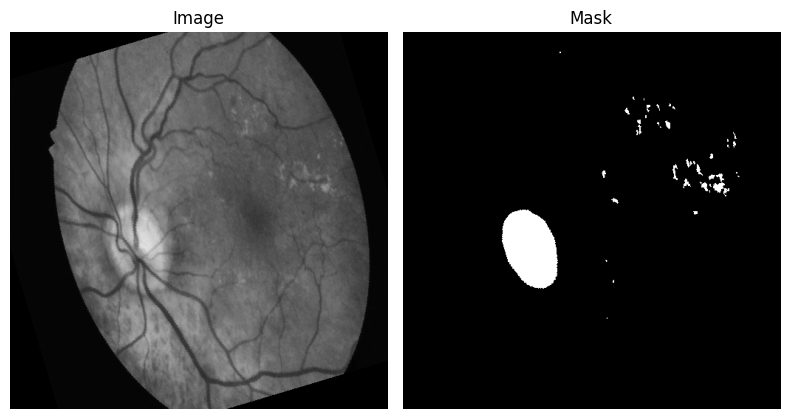

In [42]:
visualise_dataset(train_dataloader, 1)

#### Training

In [43]:
class_frequencies, pos_weight = calculate_class_weights(2, train_dataloader)
print(class_frequencies, pos_weight)

[40819997.  1647331.] 24.779474798932334


In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion_list = [torch.nn.BCEWithLogitsLoss(),
                  torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to(device)),
                  torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4, dtype=torch.float32).to(device)),
                  DiceLoss(),
                  FocalLoss(weights=torch.tensor(4).to(device)),
                  TverskyLoss(),
                  TverskyLoss(0.25),
                  TverskyLoss(0.75),
                  FocalTverskyLoss(),
                  FocalTverskyLoss(0.25),
                  FocalTverskyLoss(0.75),
                  LogCoshDice()]

model_names = ["BCEnoPOS",
               "BCECalcPOS",
               "BCE4POS",
               "DiceLoss",
               "FocalLoss",
               "TverskyLossBase",
               "TverskyLoss25",
               "TverskyLoss75",
               "FocalTverskyLossBase",
               "FocalTverskyLoss25",
               "FocalTverskyLoss75",
               "LogCoshDice"]

loss_dataframe = pd.DataFrame()

torch.cuda.empty_cache()
gc.collect()

for idx, criterion in enumerate(criterion_list):
    #initialise new Unet model and optimiser
    model = uNetModel(1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    print(f"Training {model_names[idx]} model")
    #train unet for the specific criterion
    training_loss = train_unet(model, 
                               criterion, 
                               optimizer,
                               train_dataloader,
                               50,
                               device,
                               "lesion/binary",
                               model_names[idx])
    
    loss_dataframe[model_names[idx]] = training_loss

    #clear cuda memory
    del model
    torch.cuda.empty_cache()
    gc.collect()

#saving data
loss_dataframe.to_csv('results/lesion_binary.csv')

#### Evaluation

In [61]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_names = ["binary/BCEnoPOS",
               "binary/BCECalcPOS",
               "binary/BCE4POS",
               "binary/DiceLoss",
               "binary/FocalLoss",
               "binary/TverskyLossBase",
               "binary/TverskyLoss25",
               "binary/TverskyLoss75",
               "binary/FocalTverskyLossBase",
               "binary/FocalTverskyLoss25",
               "binary/FocalTverskyLoss75",
               "binary/LogCoshDice"]

models_list = []

#loading models
for model_name in model_names:
    model = torch.load(f"../models/lesion/{model_name}.pt")
    model_last = torch.load(f"../models/lesion/{model_name}_50.pt")
    models_list.append([model, model_last])

In [62]:
results = pd.DataFrame(columns=['model', 'dice coefficient', 'jaccard index'])

for idx, (best_model, last_model) in enumerate(models_list):
    torch.cuda.empty_cache()
    gc.collect()

    #get the dice coefficient and jaccard index for best and last model
    b_dice_coe, b_jaccard = eval_unet(best_model, False, test_dataloader, device)
    l_dice_coe, l_jaccard = eval_unet(last_model, False, test_dataloader, device)

    #store results
    results.loc[len(results)] = [f"{model_names[idx]}_best", b_dice_coe, b_jaccard]
    results.loc[len(results)] = [f"{model_names[idx]}_last", l_dice_coe, l_jaccard]

#saving data
results.to_csv('results/lesion_binary_results.csv')

Average Dice Coefficient: 0.6487987694513286
Average Jaccard Index: 0.480674127514322
Average Dice Coefficient: 0.6487987694513286
Average Jaccard Index: 0.480674127514322
Average Dice Coefficient: 0.6263352691412728
Average Jaccard Index: 0.45657719792205215
Average Dice Coefficient: 0.5212941719164877
Average Jaccard Index: 0.35312251192863336
Average Dice Coefficient: 0.7332796702130276
Average Jaccard Index: 0.5796318408788887
Average Dice Coefficient: 0.7344574333261269
Average Jaccard Index: 0.5818263850367236
Average Dice Coefficient: 0.7880173832320265
Average Jaccard Index: 0.6510113281097517
Average Dice Coefficient: 0.7880173832320265
Average Jaccard Index: 0.6510113281097517
Average Dice Coefficient: 0.6245579199466874
Average Jaccard Index: 0.4545620772179568
Average Dice Coefficient: 0.6593294670068267
Average Jaccard Index: 0.4923578991388642
Average Dice Coefficient: 0.674353159848728
Average Jaccard Index: 0.5097445109160249
Average Dice Coefficient: 0.7156047369252145

#### Inference

In [48]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_names = ["binary/BCEnoPOS",
               "binary/BCECalcPOS",
               "binary/BCE4POS",
               "binary/DiceLoss",
               "binary/FocalLoss",
               "binary/TverskyLossBase",
               "binary/TverskyLoss25",
               "binary/TverskyLoss75",
               "binary/FocalTverskyLossBase",
               "binary/FocalTverskyLoss25",
               "binary/FocalTverskyLoss75",
               "binary/LogCoshDice"]

models_list = []

#loading models
for model_name in model_names:
    model = torch.load(f"../models/lesion/{model_name}.pt")
    model_last = torch.load(f"../models/lesion/{model_name}_50.pt")
    models_list.append([model, model_last])

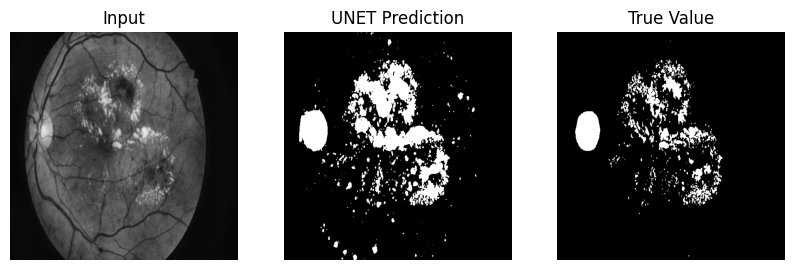

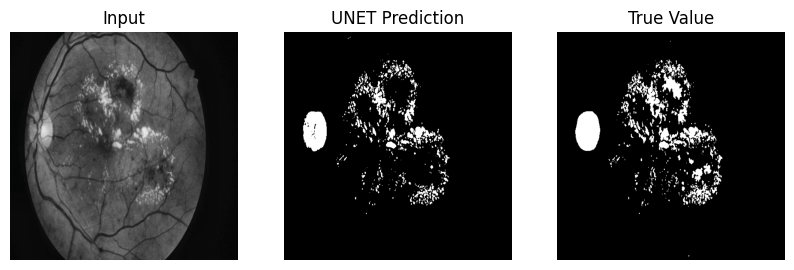

In [65]:
best_model, model_type = models_list[1]
torch.cuda.empty_cache()
gc.collect()

#model inference
result = inference_unet(best_model, False, test_dataloader, 1, device)
result = inference_unet(last_model, False, test_dataloader, 1, device)

### MultiClass Image Segmentation

In [15]:
class MultiClassSegmentationDataset(Dataset):
    def __init__(self, image_paths:str, mask_paths:str, mask_class:list, transform, masktransform, mean:list, std:list):
        """
        Function to convert image folder to BINARY dataset

        Args:
            image_paths (str): string path to image folder
            mask_paths (str): string path to mask folder
            mask_class (list): list containing all the mask classes in the format of [[class 1 folder name, class 1 image annotation], [], ...]
            transform: pyTorch Image transforms
            masktransform: pyTorch Mask transforms
            mean (list): mean to normalise image
            std (list): std to normalise image
        """
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.mask_class = mask_class        
        self.transform = transform
        self.masktransform = masktransform
        self.mean = mean
        self.std = std
        
        self.image_list = os.listdir(image_paths) #all image names
        self.mask_list = []
        for dir in mask_class:
            self.mask_list.append(os.listdir(f"{mask_paths}/{dir[0]}")) #all mask names for each class 


    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_name = self.image_list[idx]
        image_path = f"{self.image_paths}/{image_name}"
        image = Image.open(image_path)  #read image
        enhanced_image = enhance_contrast(image, False) #enhance contrast of image
        merged_mask = np.zeros((image.size[1],image.size[0]), dtype=np.uint8) #create base mask

        for class_idx, mask_dir in enumerate(self.mask_class):
            mask_name = f"{image_name[:-4]}_{mask_dir[1]}.tif" #create mask name which is image_name_{class annotation}.tif
            if mask_name in self.mask_list[class_idx]: #if inside the folder (exist)
                mask = Image.open(f"{self.mask_paths}/{mask_dir[0]}/{mask_name}").convert('L') #read and convert to greyscale
                mask_array = np.array(mask)
                merged_mask[mask_array > 0] = class_idx+1 #obtain mask and convert them to class idx +1
                
            
        mask = Image.fromarray(merged_mask) #create mask image

        seed = np.random.randint(2147483647) # make a seed with numpy generator

        if self.transform is not None:
            random.seed(seed) # apply this seed to img transforms
            torch.manual_seed(seed)
            enhanced_image = self.transform(enhanced_image)
            random.seed(seed) # apply this seed to img transforms
            torch.manual_seed(seed)
            mask = self.masktransform(mask)


        #normalising image
        mean = torch.tensor(self.mean).reshape(-1, 1, 1)
        std = torch.tensor(self.std).reshape(-1, 1, 1)

        enhanced_image = ( enhanced_image - mean )/std

        return enhanced_image, mask

In [16]:
#hyper parameters
image_size = (512,512)
batch_size = 9

In [17]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize(image_size),
    ToTensorWithoutScaling()
])

aug_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation((-45,45)),
    transforms.ToTensor(),
])

mask_aug_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation((-45,45)),
    ToTensorWithoutScaling()
])

train_mask_file = "../input/IDRID/A.%20Segmentation/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set"
test_mask_file = "../input/IDRID/A.%20Segmentation/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set"
class_path = [["1. Microaneurysms","MA"], ["2. Haemorrhages","HE"], ["3. Hard Exudates","EX"], ["4. Soft Exudates","SE"], ["5. Optic Disc", "OD"]]

# Initialize your dataset - 1/3 unagumented and 2/3 augmented
multiclass_train_dataset = MultiClassSegmentationDataset(image_paths = '../input/IDRID/A.%20Segmentation/A. Segmentation/1. Original Images/a. Training Set',
                              mask_paths = train_mask_file,
                              mask_class=class_path,
                              transform=transform,
                              masktransform=mask_transform,
                              mean=[0.2816, 0.2817, 0.2816],
                              std=[0.1992, 0.1991, 0.1991])
total_data = [multiclass_train_dataset]
#augmented data
for i in range(2):
  augmented_data = MultiClassSegmentationDataset(image_paths = '../input/IDRID/A.%20Segmentation/A. Segmentation/1. Original Images/a. Training Set',
                              mask_paths = train_mask_file,
                              mask_class=class_path,
                              transform=aug_transform,
                              masktransform=mask_aug_transform,
                              mean=[0.2816, 0.2817, 0.2816],
                              std=[0.1992, 0.1991, 0.1991])
  total_data.append(augmented_data)

multiclass_total_train_dataset = ConcatDataset(total_data)

multiclass_test_dataset = MultiClassSegmentationDataset(image_paths = '../input/IDRID/A.%20Segmentation/A. Segmentation/1. Original Images/b. Testing Set',
                              mask_paths = test_mask_file,
                              mask_class=class_path,
                              transform=transform,
                              masktransform=mask_transform,
                              mean=[0.2816, 0.2817, 0.2816],
                              std=[0.1992, 0.1991, 0.1991])

# Initialize the dataloader
multiclass_train_dataloader = DataLoader(multiclass_total_train_dataset, batch_size=batch_size, shuffle=True)
multiclass_test_dataloader = DataLoader(multiclass_test_dataset, batch_size=batch_size, shuffle=False)

Image batch shape: torch.Size([9, 3, 512, 512])
Masks batch shape: torch.Size([9, 1, 512, 512])


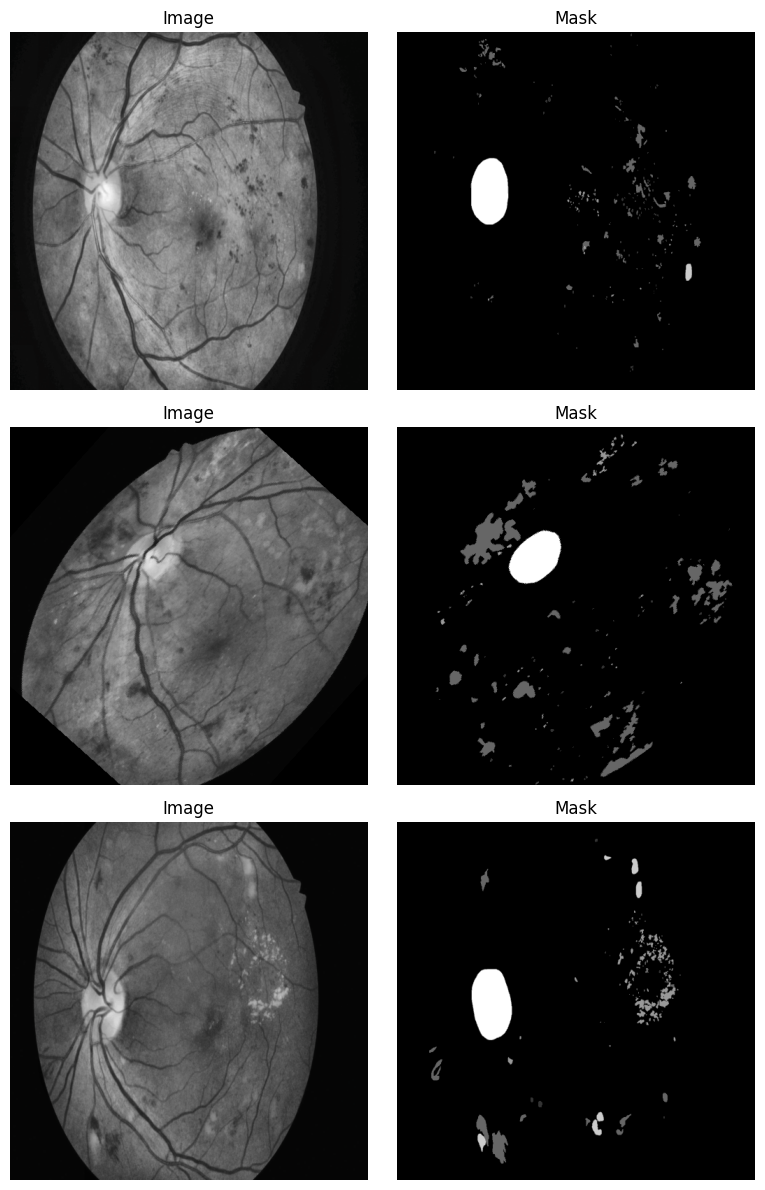

In [20]:
visualise_dataset(multiclass_train_dataloader, 3)

#### Training

In [71]:
class_frequencies, class_weights = calculate_class_weights(6, multiclass_train_dataloader)
print(class_frequencies, class_weights)

[40622243.   280299.   492622.   244955.    82783.   744426.] [0.0010644  0.15425764 0.08777168 0.17651512 0.52230847 0.05808269]


In [56]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion_list = [torch.nn.CrossEntropyLoss(),
                  torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device)),
                  torch.nn.CrossEntropyLoss(weight=torch.tensor([1, 3, 3, 3, 3, 2], dtype=torch.float32).to(device)),
                  DiceLoss(),
                  FocalLoss(weights=torch.tensor([1, 3, 3, 3, 3, 2], dtype=torch.float32).to(device)),
                  TverskyLoss(),
                  TverskyLoss(0.25),
                  TverskyLoss(0.75),
                  FocalTverskyLoss(),
                  FocalTverskyLoss(0.25),
                  FocalTverskyLoss(0.75),
                  LogCoshDice()]

model_names = ["CEL",
               "CELCalcWeights",
               "CELCustWeights",
               "DiceLoss",
               "FocalLoss",
               "TverskyLossBase",
               "TverskyLoss25",
               "TverskyLoss75",
               "FocalTverskyLossBase",
               "FocalTverskyLoss25",
               "FocalTverskyLoss75",  
               "LogCoshDice"]

multiclass_loss_dataframe = pd.DataFrame()

torch.cuda.empty_cache()
gc.collect()

for idx, criterion in enumerate(criterion_list):
    #initialise new Unet model and optimiser
    model = uNetModel(6)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    print(f"Training {model_names[idx]} model")
    #train unet for the specific criterion
    training_loss = train_unet(model, 
                               criterion, 
                               optimizer,
                               multiclass_train_dataloader,
                               50,
                               device,
                               "lesion/multiclass",
                               model_names[idx])
    
    multiclass_loss_dataframe[model_names[idx]] = training_loss
    
    #clear cuda memory
    del model
    torch.cuda.empty_cache()
    gc.collect()

#saving data
multiclass_loss_dataframe.to_csv('results/lesion_multiclass.csv')

#### Evaluation

In [73]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_names = ["multiclass/CEL",
               "multiclass/CELCalcWeights",
               "multiclass/CELCustWeights",
               "multiclass/DiceLoss",
               "multiclass/FocalLoss",
               "multiclass/TverskyLossBase",
               "multiclass/TverskyLoss25",
               "multiclass/TverskyLoss75",
               "multiclass/FocalTverskyLossBase",
               "multiclass/FocalTverskyLoss25",
               "multiclass/FocalTverskyLoss75",  
               "multiclass/LogCoshDice"]

models_list = []

#loading models
for model_name in model_names:
    model = torch.load(f"../models/lesion/{model_name}.pt")
    model_last = torch.load(f"../models/lesion/{model_name}_50.pt")
    models_list.append([model, model_last])

In [74]:
results = pd.DataFrame(columns=['model', 'dice coefficient', 'jaccard index'])

for idx, (best_model, last_model) in enumerate(models_list):
    torch.cuda.empty_cache()
    gc.collect()
    
    #get the dice coefficient and jaccard index for best and last model
    b_dice_coe, b_jaccard = eval_unet(best_model, True, multiclass_test_dataloader, device)
    l_dice_coe, l_jaccard = eval_unet(last_model, True, multiclass_test_dataloader, device)

    #store results
    results.loc[len(results)] = [f"{model_names[idx]}_best", b_dice_coe, b_jaccard]
    results.loc[len(results)] = [f"{model_names[idx]}_last", l_dice_coe, l_jaccard]

#saving data
results.to_csv('results/lesion_multiclass_results.csv')

Average Dice Coefficient: 0.5604691628791048
Average Jaccard Index: 0.45124302579539166
Average Dice Coefficient: 0.5763916571290243
Average Jaccard Index: 0.4729511459440366
Average Dice Coefficient: 0.4975157548375751
Average Jaccard Index: 0.40496478236341077
Average Dice Coefficient: 0.3846886024041149
Average Jaccard Index: 0.2883877655341756
Average Dice Coefficient: 0.6100291766259264
Average Jaccard Index: 0.5015566401181502
Average Dice Coefficient: 0.6276173055270652
Average Jaccard Index: 0.5154720616040892
Average Dice Coefficient: 0.6312580076204019
Average Jaccard Index: 0.5142738919605621
Average Dice Coefficient: 0.6448146445726787
Average Jaccard Index: 0.5327281733068149
Average Dice Coefficient: 0.5472436703490632
Average Jaccard Index: 0.44350320579688796
Average Dice Coefficient: 0.547256846137954
Average Jaccard Index: 0.44218798858142466
Average Dice Coefficient: 0.6424802783968634
Average Jaccard Index: 0.5257286295104672
Average Dice Coefficient: 0.614405111807

#### Inference

In [59]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion_list = [torch.nn.CrossEntropyLoss(),
                  torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device)),
                  torch.nn.CrossEntropyLoss(weight=torch.tensor([1, 3, 3, 3, 3, 2], dtype=torch.float32).to(device)),
                  DiceLoss(),
                  FocalLoss(weights=torch.tensor([1, 3, 3, 3, 3, 2], dtype=torch.float32).to(device)),
                  TverskyLoss(),
                  TverskyLoss(0.25),
                  TverskyLoss(0.75),
                  FocalTverskyLoss(),
                  FocalTverskyLoss(0.25),
                  FocalTverskyLoss(0.75),
                  LogCoshDice()]


model_names = ["multiclass/CEL",
               "multiclass/CELCalcWeights",
               "multiclass/CELCustWeights",
               "multiclass/DiceLoss",
               "multiclass/FocalLoss",
               "multiclass/TverskyLossBase",
               "multiclass/TverskyLoss25",
               "multiclass/TverskyLoss75",
               "multiclass/FocalTverskyLossBase",
               "multiclass/FocalTverskyLoss25",
               "multiclass/FocalTverskyLoss75",  
               "multiclass/LogCoshDice"]

models_list = []

#loading models
for model_name in model_names:
    model = torch.load(f"../models/lesion/{model_name}.pt")
    model_last = torch.load(f"../models/lesion/{model_name}_50.pt")
    models_list.append([model, model_last])

In [60]:
best_model, last_model = models_list[1]
torch.cuda.empty_cache()
gc.collect()

#model inference
inference_unet(best_model, True, multiclass_test_dataloader, 1, device)
inference_unet(last_model, True, multiclass_test_dataloader, 1, device)

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion_list = [DiceLoss(),
                  TverskyLoss(0.25),
                  FocalTverskyLoss(0.25),
                  LogCoshDice()]


model_names = ["DiceLoss",
               "TverskyLoss25",
               "FocalTverskyLoss25",
               "LogCoshDice"]


multiclass_loss_dataframe = pd.DataFrame()

torch.cuda.empty_cache()
gc.collect()

for idx, criterion in enumerate(criterion_list):
    model = torch.load(f'../models/lesion/multiclass/{model_names[idx]}_50.pt')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    torch.cuda.empty_cache()
    gc.collect()
    training_loss = train_unet(model, 
                                criterion, 
                                optimizer,
                                multiclass_train_dataloader,
                                50,
                                device,
                                "lesion/multiclass",
                                f"{model_names[idx]}_2")
    
    multiclass_loss_dataframe[model_names[idx]] = training_loss
    
    #clear cuda memory
    del model
    torch.cuda.empty_cache()
    gc.collect()

multiclass_loss_dataframe.to_csv('results/lesion_100_multiclass.csv')

100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 1 completed, training loss: 0.41


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 2 completed, training loss: 0.40


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 3 completed, training loss: 0.41


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 4 completed, training loss: 0.40


100%|██████████| 18/18 [00:47<00:00,  2.63s/it]


Epoch 5 completed, training loss: 0.40


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 6 completed, training loss: 0.40


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 7 completed, training loss: 0.40


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 8 completed, training loss: 0.39


100%|██████████| 18/18 [00:47<00:00,  2.61s/it]


Epoch 9 completed, training loss: 0.39


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 10 completed, training loss: 0.40


100%|██████████| 18/18 [00:47<00:00,  2.63s/it]


Epoch 11 completed, training loss: 0.40


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 12 completed, training loss: 0.40


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 13 completed, training loss: 0.39


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 14 completed, training loss: 0.39


100%|██████████| 18/18 [00:47<00:00,  2.61s/it]


Epoch 15 completed, training loss: 0.39


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 16 completed, training loss: 0.39


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 17 completed, training loss: 0.39


100%|██████████| 18/18 [00:47<00:00,  2.66s/it]


Epoch 18 completed, training loss: 0.38


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 19 completed, training loss: 0.39


100%|██████████| 18/18 [00:49<00:00,  2.74s/it]


Epoch 20 completed, training loss: 0.39


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 21 completed, training loss: 0.39


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 22 completed, training loss: 0.39


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 23 completed, training loss: 0.39


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 24 completed, training loss: 0.38


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 25 completed, training loss: 0.39


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 26 completed, training loss: 0.39


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 27 completed, training loss: 0.38


100%|██████████| 18/18 [00:47<00:00,  2.61s/it]


Epoch 28 completed, training loss: 0.38


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 29 completed, training loss: 0.39


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 30 completed, training loss: 0.38


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 31 completed, training loss: 0.38


100%|██████████| 18/18 [00:47<00:00,  2.61s/it]


Epoch 32 completed, training loss: 0.38


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 33 completed, training loss: 0.39


100%|██████████| 18/18 [00:47<00:00,  2.61s/it]


Epoch 34 completed, training loss: 0.38


100%|██████████| 18/18 [00:47<00:00,  2.61s/it]


Epoch 35 completed, training loss: 0.38


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 36 completed, training loss: 0.38


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 37 completed, training loss: 0.37


100%|██████████| 18/18 [00:47<00:00,  2.63s/it]


Epoch 38 completed, training loss: 0.38


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 39 completed, training loss: 0.38


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 40 completed, training loss: 0.38


100%|██████████| 18/18 [00:47<00:00,  2.61s/it]


Epoch 41 completed, training loss: 0.38


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 42 completed, training loss: 0.38


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 43 completed, training loss: 0.37


100%|██████████| 18/18 [00:47<00:00,  2.61s/it]


Epoch 44 completed, training loss: 0.37


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 45 completed, training loss: 0.38


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 46 completed, training loss: 0.38


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 47 completed, training loss: 0.38


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 48 completed, training loss: 0.37


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 49 completed, training loss: 0.37


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 50 completed, training loss: 0.37


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 1 completed, training loss: 0.40


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 2 completed, training loss: 0.39


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 3 completed, training loss: 0.39


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 4 completed, training loss: 0.39


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 5 completed, training loss: 0.39


100%|██████████| 18/18 [00:47<00:00,  2.61s/it]


Epoch 6 completed, training loss: 0.39


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 7 completed, training loss: 0.39


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 8 completed, training loss: 0.38


100%|██████████| 18/18 [00:47<00:00,  2.61s/it]


Epoch 9 completed, training loss: 0.38


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 10 completed, training loss: 0.38


100%|██████████| 18/18 [00:47<00:00,  2.63s/it]


Epoch 11 completed, training loss: 0.38


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 12 completed, training loss: 0.38


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 13 completed, training loss: 0.38


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 14 completed, training loss: 0.38


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 15 completed, training loss: 0.38


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 16 completed, training loss: 0.38


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 17 completed, training loss: 0.38


100%|██████████| 18/18 [00:49<00:00,  2.73s/it]


Epoch 18 completed, training loss: 0.38


100%|██████████| 18/18 [00:48<00:00,  2.71s/it]


Epoch 19 completed, training loss: 0.38


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 20 completed, training loss: 0.38


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 21 completed, training loss: 0.37


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 22 completed, training loss: 0.38


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 23 completed, training loss: 0.38


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 24 completed, training loss: 0.37


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 25 completed, training loss: 0.37


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 26 completed, training loss: 0.38


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 27 completed, training loss: 0.38


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 28 completed, training loss: 0.37


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 29 completed, training loss: 0.37


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 30 completed, training loss: 0.37


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 31 completed, training loss: 0.37


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 32 completed, training loss: 0.37


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 33 completed, training loss: 0.37


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 34 completed, training loss: 0.37


100%|██████████| 18/18 [00:47<00:00,  2.61s/it]


Epoch 35 completed, training loss: 0.37


100%|██████████| 18/18 [00:47<00:00,  2.61s/it]


Epoch 36 completed, training loss: 0.37


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 37 completed, training loss: 0.37


100%|██████████| 18/18 [00:47<00:00,  2.61s/it]


Epoch 38 completed, training loss: 0.37


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 39 completed, training loss: 0.37


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 40 completed, training loss: 0.37


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 41 completed, training loss: 0.37


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 42 completed, training loss: 0.37


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 43 completed, training loss: 0.37


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 44 completed, training loss: 0.36


100%|██████████| 18/18 [00:46<00:00,  2.59s/it]


Epoch 45 completed, training loss: 0.37


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 46 completed, training loss: 0.36


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 47 completed, training loss: 0.36


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 48 completed, training loss: 0.36


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 49 completed, training loss: 0.36


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 50 completed, training loss: 0.36


100%|██████████| 18/18 [00:47<00:00,  2.64s/it]


Epoch 1 completed, training loss: 0.30


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 2 completed, training loss: 0.29


100%|██████████| 18/18 [00:47<00:00,  2.64s/it]


Epoch 3 completed, training loss: 0.29


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 4 completed, training loss: 0.29


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 5 completed, training loss: 0.29


100%|██████████| 18/18 [00:48<00:00,  2.70s/it]


Epoch 6 completed, training loss: 0.29


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 7 completed, training loss: 0.29


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 8 completed, training loss: 0.29


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 9 completed, training loss: 0.28


100%|██████████| 18/18 [00:47<00:00,  2.61s/it]


Epoch 10 completed, training loss: 0.28


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 11 completed, training loss: 0.28


100%|██████████| 18/18 [00:47<00:00,  2.61s/it]


Epoch 12 completed, training loss: 0.28


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 13 completed, training loss: 0.28


100%|██████████| 18/18 [00:47<00:00,  2.61s/it]


Epoch 14 completed, training loss: 0.29


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 15 completed, training loss: 0.28


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 16 completed, training loss: 0.28


100%|██████████| 18/18 [00:47<00:00,  2.61s/it]


Epoch 17 completed, training loss: 0.28


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 18 completed, training loss: 0.28


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 19 completed, training loss: 0.28


100%|██████████| 18/18 [00:48<00:00,  2.69s/it]


Epoch 20 completed, training loss: 0.28


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 21 completed, training loss: 0.27


100%|██████████| 18/18 [00:47<00:00,  2.61s/it]


Epoch 22 completed, training loss: 0.27


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 23 completed, training loss: 0.28


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 24 completed, training loss: 0.28


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 25 completed, training loss: 0.28


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 26 completed, training loss: 0.28


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 27 completed, training loss: 0.28


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 28 completed, training loss: 0.28


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 29 completed, training loss: 0.27


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 30 completed, training loss: 0.27


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 31 completed, training loss: 0.27


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 32 completed, training loss: 0.27


100%|██████████| 18/18 [00:47<00:00,  2.63s/it]


Epoch 33 completed, training loss: 0.27


100%|██████████| 18/18 [00:48<00:00,  2.68s/it]


Epoch 34 completed, training loss: 0.27


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 35 completed, training loss: 0.27


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 36 completed, training loss: 0.27


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 37 completed, training loss: 0.27


100%|██████████| 18/18 [00:47<00:00,  2.61s/it]


Epoch 38 completed, training loss: 0.27


100%|██████████| 18/18 [00:46<00:00,  2.59s/it]


Epoch 39 completed, training loss: 0.27


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 40 completed, training loss: 0.27


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 41 completed, training loss: 0.27


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 42 completed, training loss: 0.27


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 43 completed, training loss: 0.27


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 44 completed, training loss: 0.27


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 45 completed, training loss: 0.27


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 46 completed, training loss: 0.27


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 47 completed, training loss: 0.27


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 48 completed, training loss: 0.27


100%|██████████| 18/18 [00:48<00:00,  2.67s/it]


Epoch 49 completed, training loss: 0.27


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 50 completed, training loss: 0.26


100%|██████████| 18/18 [00:47<00:00,  2.66s/it]


Epoch 1 completed, training loss: 0.09


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 2 completed, training loss: 0.08


100%|██████████| 18/18 [00:47<00:00,  2.65s/it]


Epoch 3 completed, training loss: 0.08


100%|██████████| 18/18 [00:47<00:00,  2.64s/it]


Epoch 4 completed, training loss: 0.08


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 5 completed, training loss: 0.08


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 6 completed, training loss: 0.08


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 7 completed, training loss: 0.08


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 8 completed, training loss: 0.08


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 9 completed, training loss: 0.08


100%|██████████| 18/18 [00:46<00:00,  2.59s/it]


Epoch 10 completed, training loss: 0.08


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 11 completed, training loss: 0.08


100%|██████████| 18/18 [00:46<00:00,  2.59s/it]


Epoch 12 completed, training loss: 0.08


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 13 completed, training loss: 0.08


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 14 completed, training loss: 0.08


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 15 completed, training loss: 0.08


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 16 completed, training loss: 0.08


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 17 completed, training loss: 0.08


100%|██████████| 18/18 [00:48<00:00,  2.68s/it]


Epoch 18 completed, training loss: 0.08


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 19 completed, training loss: 0.08


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 20 completed, training loss: 0.07


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 21 completed, training loss: 0.08


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 22 completed, training loss: 0.07


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 23 completed, training loss: 0.08


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 24 completed, training loss: 0.08


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 25 completed, training loss: 0.08


100%|██████████| 18/18 [00:46<00:00,  2.60s/it]


Epoch 26 completed, training loss: 0.07


100%|██████████| 18/18 [00:59<00:00,  3.29s/it]


Epoch 27 completed, training loss: 0.07


100%|██████████| 18/18 [00:55<00:00,  3.09s/it]


Epoch 28 completed, training loss: 0.07


100%|██████████| 18/18 [00:47<00:00,  2.63s/it]


Epoch 29 completed, training loss: 0.08


100%|██████████| 18/18 [00:48<00:00,  2.68s/it]


Epoch 30 completed, training loss: 0.07


100%|██████████| 18/18 [00:48<00:00,  2.69s/it]


Epoch 31 completed, training loss: 0.07


100%|██████████| 18/18 [00:47<00:00,  2.64s/it]


Epoch 32 completed, training loss: 0.07


100%|██████████| 18/18 [00:47<00:00,  2.66s/it]


Epoch 33 completed, training loss: 0.07


100%|██████████| 18/18 [00:47<00:00,  2.64s/it]


Epoch 34 completed, training loss: 0.08


100%|██████████| 18/18 [00:47<00:00,  2.64s/it]


Epoch 35 completed, training loss: 0.07


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 36 completed, training loss: 0.07


100%|██████████| 18/18 [00:47<00:00,  2.63s/it]


Epoch 37 completed, training loss: 0.07


100%|██████████| 18/18 [00:47<00:00,  2.63s/it]


Epoch 38 completed, training loss: 0.07


100%|██████████| 18/18 [00:49<00:00,  2.72s/it]


Epoch 39 completed, training loss: 0.07


100%|██████████| 18/18 [00:49<00:00,  2.76s/it]


Epoch 40 completed, training loss: 0.07


100%|██████████| 18/18 [00:47<00:00,  2.63s/it]


Epoch 41 completed, training loss: 0.07


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 42 completed, training loss: 0.07


100%|██████████| 18/18 [00:47<00:00,  2.61s/it]


Epoch 43 completed, training loss: 0.07


100%|██████████| 18/18 [00:46<00:00,  2.61s/it]


Epoch 44 completed, training loss: 0.07


100%|██████████| 18/18 [00:47<00:00,  2.63s/it]


Epoch 45 completed, training loss: 0.07


100%|██████████| 18/18 [00:47<00:00,  2.65s/it]


Epoch 46 completed, training loss: 0.07


100%|██████████| 18/18 [00:47<00:00,  2.63s/it]


Epoch 47 completed, training loss: 0.07


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Epoch 48 completed, training loss: 0.07


100%|██████████| 18/18 [00:47<00:00,  2.64s/it]


Epoch 49 completed, training loss: 0.07


100%|██████████| 18/18 [00:47<00:00,  2.65s/it]


Epoch 50 completed, training loss: 0.07


In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


model_names = ["DiceLoss",
               "TverskyLoss25",
               "FocalTverskyLoss25",
               "LogCoshDice"]


models_list = []

#loading models
for model_name in model_names:
    model = torch.load(f"../models/lesion/multiclass/{model_name}_2.pt")
    model_last = torch.load(f"../models/lesion/multiclass/{model_name}_2_50.pt")
    models_list.append([model, model_last])

In [22]:
results = pd.DataFrame(columns=['model', 'dice coefficient', 'jaccard index'])

for idx, (best_model, last_model) in enumerate(models_list):
    torch.cuda.empty_cache()
    gc.collect()
    
    #get the dice coefficient and jaccard index for best and last model
    b_dice_coe, b_jaccard = eval_unet(best_model, True, multiclass_test_dataloader, device)
    l_dice_coe, l_jaccard = eval_unet(last_model, True, multiclass_test_dataloader, device)

    #store results
    results.loc[len(results)] = [f"{model_names[idx]}_best", b_dice_coe, b_jaccard]
    results.loc[len(results)] = [f"{model_names[idx]}_last", l_dice_coe, l_jaccard]

#saving data
results.to_csv('results/multiclass_results.csv')

Average Dice Coefficient: 0.6597552257192519
Average Jaccard Index: 0.5461796591006262
Average Dice Coefficient: 0.6597552257192519
Average Jaccard Index: 0.5461796591006262
Average Dice Coefficient: 0.6315862814862693
Average Jaccard Index: 0.5195503579917639
Average Dice Coefficient: 0.6422379718413952
Average Jaccard Index: 0.5265591114172744
Average Dice Coefficient: 0.6440714688740087
Average Jaccard Index: 0.5305957821922224
Average Dice Coefficient: 0.6440714688740087
Average Jaccard Index: 0.5305957821922224
Average Dice Coefficient: 0.6506494015366489
Average Jaccard Index: 0.5401831612731364
Average Dice Coefficient: 0.6538636114047373
Average Jaccard Index: 0.542498996402759
